In [1]:
using Graphs
using Bloqade
using Random
using GenericTensorNetworks
using Optim
using Bloqade.CairoMakie

In [2]:
function MIS_QAA(graph)
    T_max = 0.6
    Ω_max = 2π * 4
    Ω = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [0.0, Ω_max, Ω_max, 0])
    Δ_start = -2π * 13
    Δ_end = 2π * 11
    Δ = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])
    hamiltonian = rydberg_h(atoms; Ω = Ω, Δ = Δ)
    prob = SchrodingerProblem(zero_state(nqubits(hamiltonian)), T_max, hamiltonian)
    emulate!(prob)
    best_bit_strings = most_probable(prob.reg, 3)
    return [mis_postprocessing(val, graph) for val in best_bit_strings]
end

MIS_QAA (generic function with 1 method)

In [238]:
function coloring(atoms, find_colors, color, result, minres)
    if size(find_colors,1) == 0
        return result
    end
    graph = BloqadeMIS.unit_disk_graph(find_colors, 7.5)
    res = MIS_QAA(graph)
    for bitstring in res
        to_delete = []
        for (i, b) in enumerate(bitstring)
            if b
                idx = findfirst(elem -> elem == find_colors[i], atoms)
                push!(to_delete, atoms[idx])
                result[atoms[idx]] = color
            end
        end
        optres = coloring(atoms, [elem for (i, elem) in enumerate(find_colors) if !(elem in to_delete)], color+1, result, minres)
        if isempty(minres) || findmax(optres)[1] < findmax(minres)[1]
            minres = copy(optres)
        end
    end
    return minres
end

coloring (generic function with 2 methods)

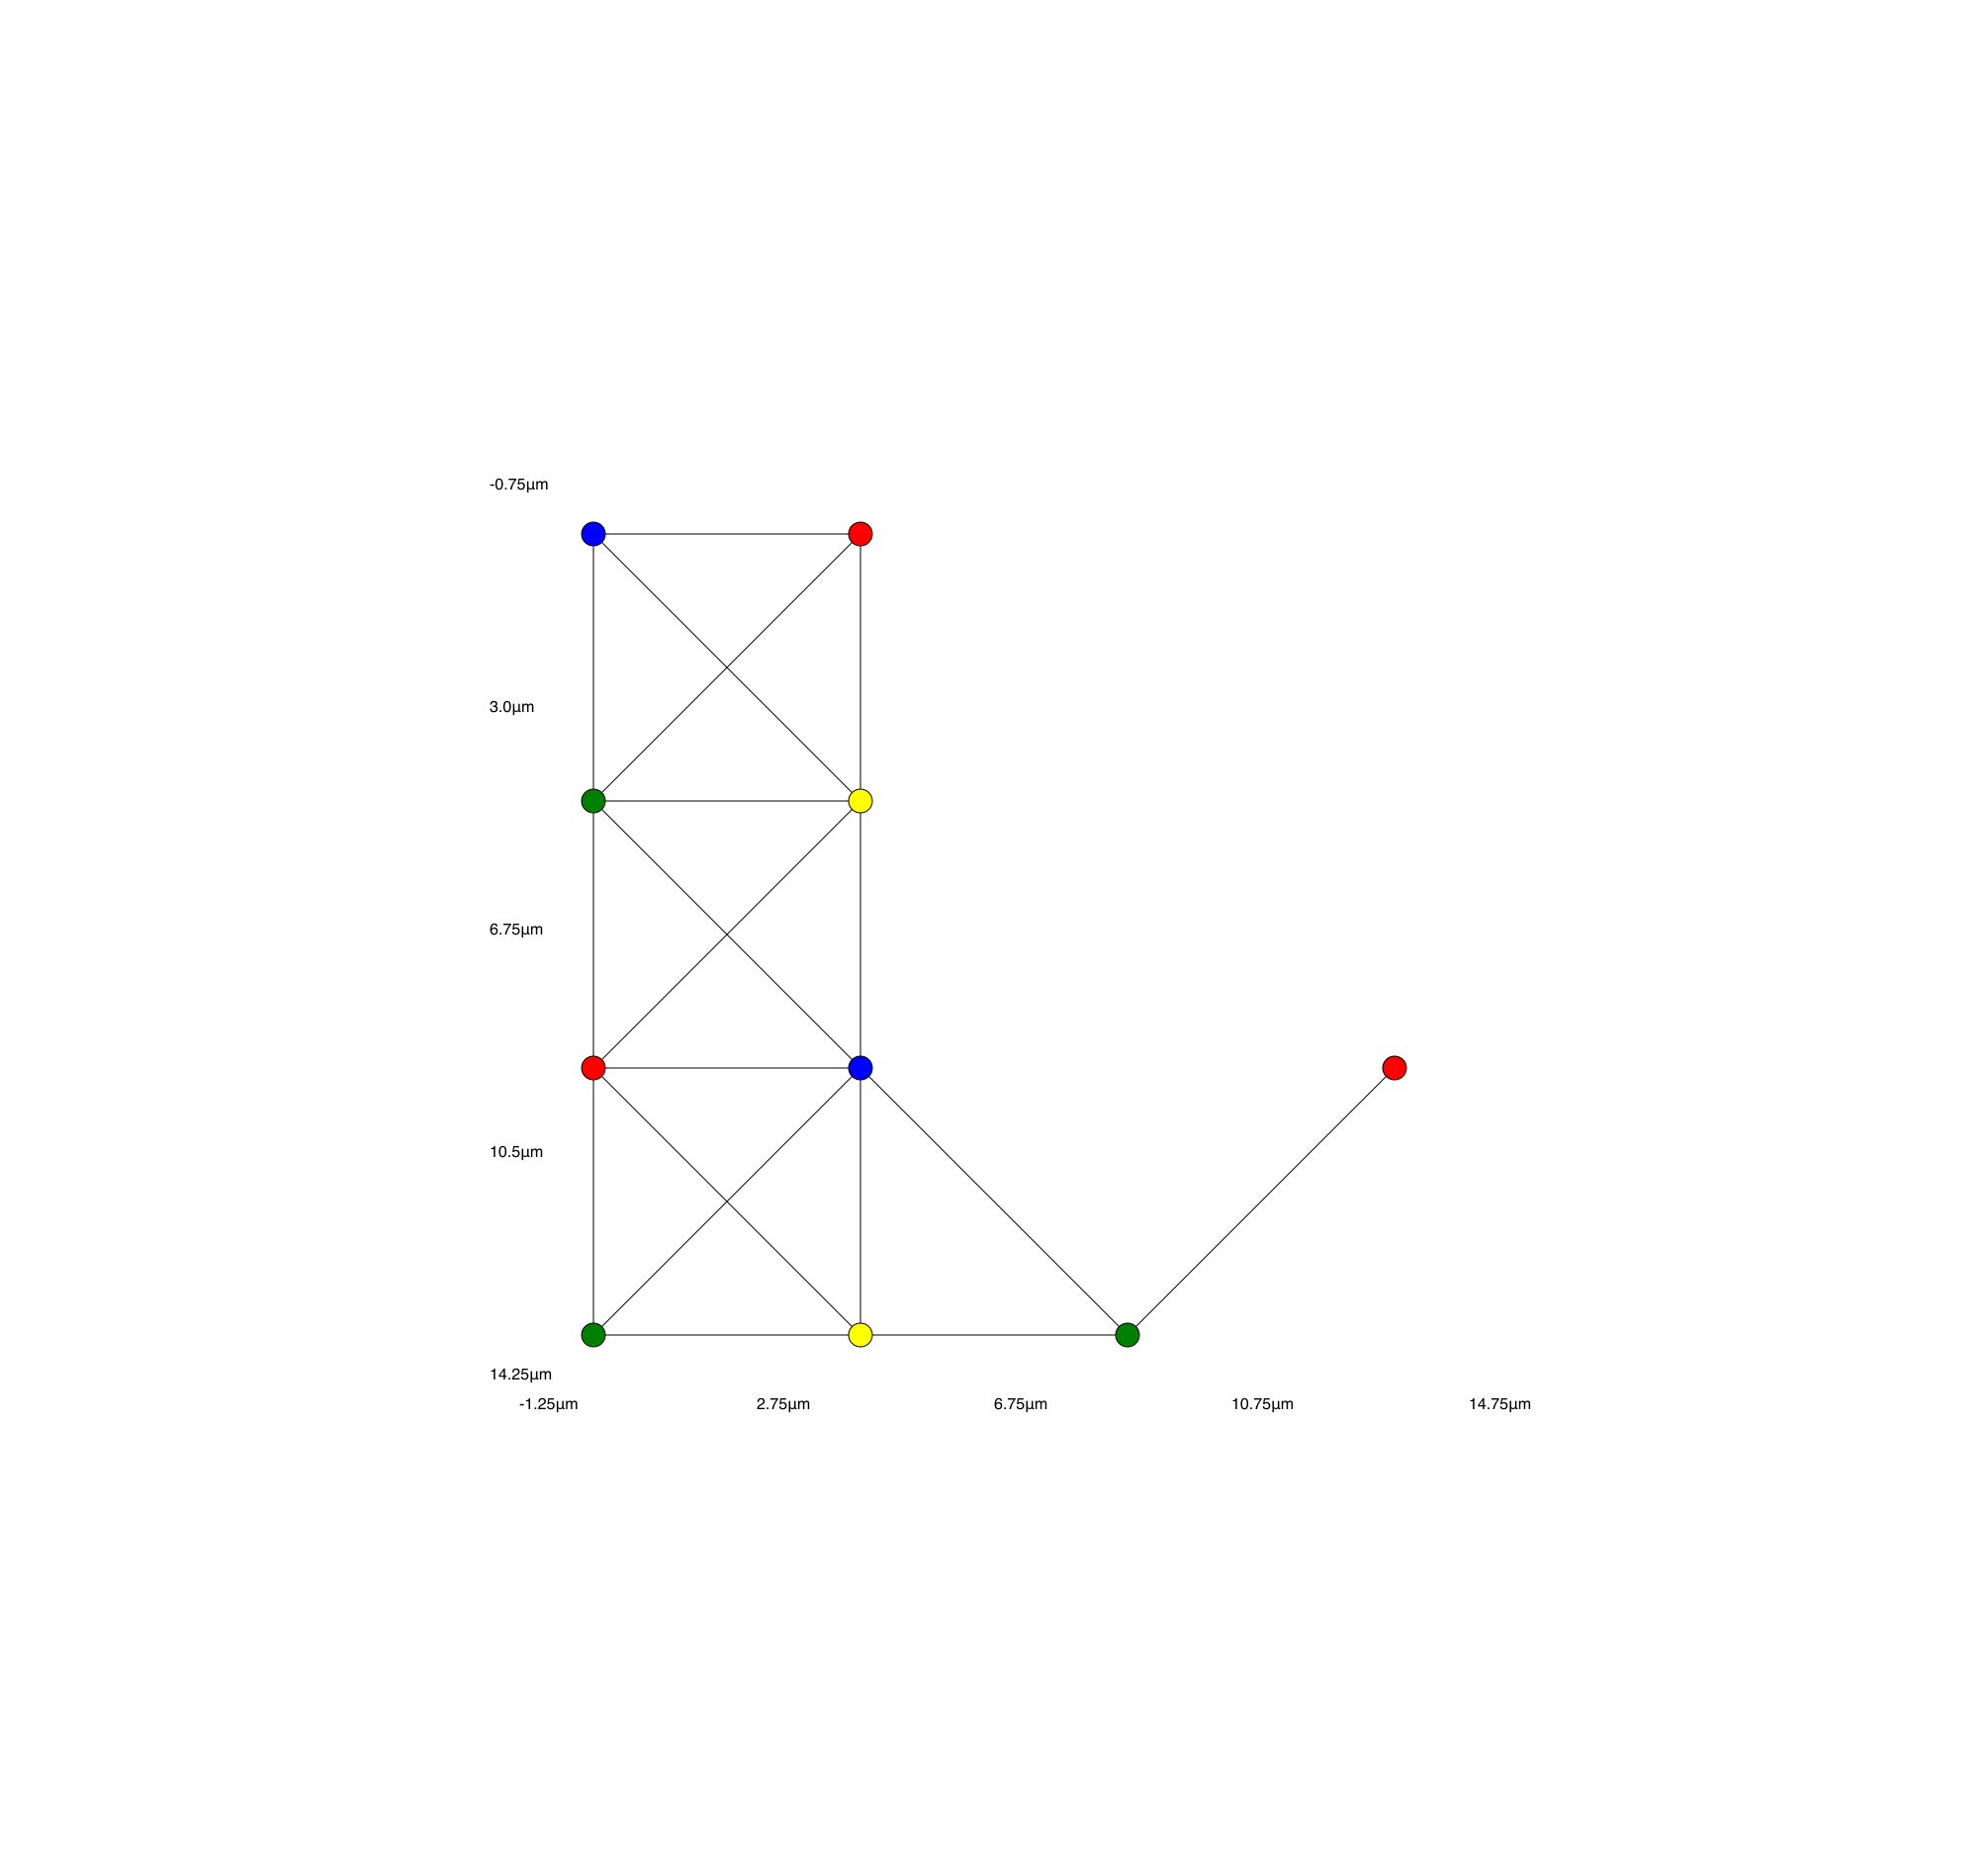

In [240]:
Random.seed!(4)
atoms = generate_sites(SquareLattice(), 4, 4; scale = 4.5) |> random_dropout(0.4)
output = coloring(atoms, copy(atoms), 1, Dict(), Dict())
colors = Dict(1 => "red", 2 => "green", 3 => "blue", 4 => "yellow", 5 => "purple")
Bloqade.plot(atoms, blockade_radius = 7.5; colors = [colors[output[elem]] for elem in atoms])